In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [2]:
# Define the file paths for the dataset
train_dir = '/content/gdrive/My Drive/asl_alphabet_train'

In [3]:
# Define the file paths for the dataset
test_dir = '/content/gdrive/My Drive/asl_alphabet_test'

In [4]:
# Create a list of folders' names for each ASL symbol
folder = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z','del','nothing','space']

In [5]:
# Import packages and set numpy random seed
import random
import numpy as np
from os.path import join
from os import listdir
import matplotlib.pyplot as plt
import cv2
import skimage
from skimage.transform import resize
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.preprocessing import image

np.random.seed(5) 
tf.random.set_seed(2)
%matplotlib inline

# Define functions to load, shuffle, and split the data
def load_data(container_path=train_dir, folders=folder,
              size=87000, test_split=0.2, seed=0): # 3000 images in 29 classes
    """
    Loads sign language dataset.
    """
    
    filenames, labels = [], []

    for label, folder in enumerate(folders):
        folder_path = join(container_path, folder)
        images = [join(folder_path, d)
                     for d in sorted(listdir(folder_path))]
        labels.extend(len(images) * [label])
        filenames.extend(images)

        random.seed(seed)
    data = list(zip(filenames, labels))
    random.shuffle(data)
    data = data[:size]
    filenames, labels = zip(*data)

    
    # Get the images
    x = paths_to_tensor(filenames).astype('float32')/255
    # Store the one-hot targets
    y = np.array(labels)

    x_train = np.array(x[:int(len(x) * (1 - test_split))])
    y_train = np.array(y[:int(len(x) * (1 - test_split))])
    x_test = np.array(x[int(len(x) * (1 - test_split)):])
    y_test = np.array(y[int(len(x) * (1 - test_split)):])
     
    print('Loaded', len(x_train),'images for training,','Train data shape =',x_train.shape)
    print('Loaded', len(x_test),'images for testing','Test data shape =',x_test.shape)
    print('Loaded', len(x_train),'labels for training,','Train data shape =',y_train.shape)
    print('Loaded', len(x_test),'labels for testing','Test data shape =',y_test.shape)
    return (x_train, y_train), (x_test, y_test)


def path_to_tensor(img_path, size):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(size, size))
    # convert PIL.Image.Image type to 3D tensor
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor 
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths, size=50):
    list_of_tensors = [path_to_tensor(img_path, size) for img_path in img_paths]
    return np.vstack(list_of_tensors)

In [7]:
# Load pre-shuffled training and test datasets
(x_train, y_train), (x_test, y_test) = load_data()

Loaded 69600 images for training, Train data shape = (69600, 50, 50, 3)
Loaded 17400 images for testing Test data shape = (17400, 50, 50, 3)
Loaded 69600 labels for training, Train data shape = (69600,)
Loaded 17400 labels for testing Test data shape = (17400,)


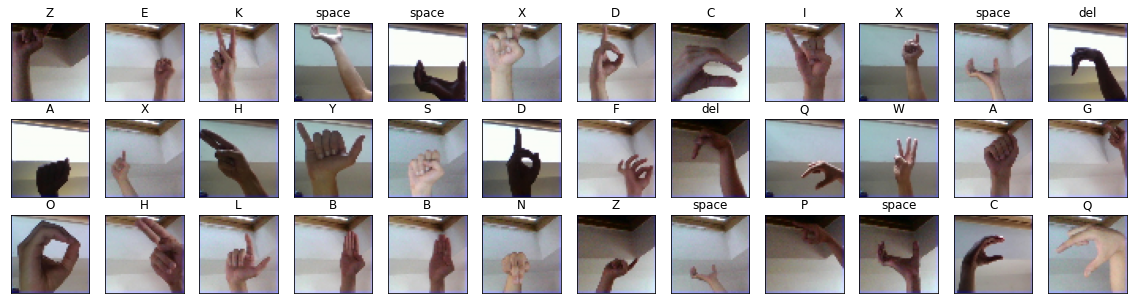

In [8]:
# Print the first several training images, along with the labels
fig = plt.figure(figsize=(20,5))
for i in range(36):
    ax = fig.add_subplot(3, 12, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_train[i]))
    ax.set_title("{}".format(folder[y_train[i]]))
plt.show()

In [9]:
labels_dict = {'A':0,'B':1,'C':2,'D':3,'E':4,'F':5,'G':6,'H':7,'I':8,'J':9,'K':10,'L':11,'M':12,
                   'N':13,'O':14,'P':15,'Q':16,'R':17,'S':18,'T':19,'U':20,'V':21,'W':22,'X':23,'Y':24,
                   'Z':25,'space':26,'del':27,'nothing':28}

# Number of each symbol in the training and testing datasets
train_dict = {}
test_dict = {}
for key in labels_dict:
    train_dict[key] = sum(y_train==labels_dict[key])
    test_dict[key] = sum(y_test==labels_dict[key])

In [10]:
train_dict

{'A': 2359,
 'B': 2352,
 'C': 2423,
 'D': 2419,
 'E': 2378,
 'F': 2408,
 'G': 2395,
 'H': 2401,
 'I': 2388,
 'J': 2395,
 'K': 2399,
 'L': 2409,
 'M': 2423,
 'N': 2392,
 'O': 2359,
 'P': 2398,
 'Q': 2382,
 'R': 2389,
 'S': 2413,
 'T': 2415,
 'U': 2422,
 'V': 2422,
 'W': 2421,
 'X': 2421,
 'Y': 2420,
 'Z': 2407,
 'del': 2374,
 'nothing': 2421,
 'space': 2395}

In [11]:
test_dict

{'A': 639,
 'B': 647,
 'C': 575,
 'D': 585,
 'E': 618,
 'F': 592,
 'G': 602,
 'H': 599,
 'I': 610,
 'J': 604,
 'K': 630,
 'L': 589,
 'M': 576,
 'N': 605,
 'O': 638,
 'P': 600,
 'Q': 617,
 'R': 619,
 'S': 585,
 'T': 584,
 'U': 575,
 'V': 577,
 'W': 576,
 'X': 577,
 'Y': 578,
 'Z': 592,
 'del': 623,
 'nothing': 586,
 'space': 602}

In [12]:
# One-hot encode the training labels
y_train_OH = to_categorical(y_train)

# One-hot encode the test labels
y_test_OH = to_categorical(y_test)

In [13]:
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Flatten, Dense
from keras.models import Sequential

model = Sequential()
# First convolutional layer accepts image input
model.add(Conv2D(filters=5, kernel_size=5, padding='same', activation='relu', 
                        input_shape=(50, 50, 3)))
# Add a max pooling layer
model.add(MaxPooling2D(pool_size=(4,4)))
# Add a convolutional layer
model.add(Conv2D(filters=15, kernel_size=5, padding='same', activation='relu'))
# Add another max pooling layer
model.add(MaxPooling2D(pool_size=(4,4)))
# Flatten and feed to output layer
model.add(Flatten())
model.add(Dense(29, activation='softmax'))

# Summarize the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 50, 50, 5)         380       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 5)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 15)        1890      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 3, 3, 15)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 135)               0         
                                                                 
 dense (Dense)               (None, 29)                3

In [14]:
# Compile the model
model.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [15]:
# Train the model
hist = model.fit(x_train,y_train_OH, epochs=50, batch_size=64, validation_split=0.2)

Epoch 1/50
870/870 [==============================] - 135s 154ms/step - loss: 2.5331 - accuracy: 0.2762 - val_loss: 1.9420 - val_accuracy: 0.4251
Epoch 2/50
870/870 [==============================] - 134s 155ms/step - loss: 1.5829 - accuracy: 0.5252 - val_loss: 1.3366 - val_accuracy: 0.6037
Epoch 3/50
870/870 [==============================] - 133s 153ms/step - loss: 1.2060 - accuracy: 0.6327 - val_loss: 1.1279 - val_accuracy: 0.6631
Epoch 4/50
870/870 [==============================] - 134s 154ms/step - loss: 0.9835 - accuracy: 0.6969 - val_loss: 0.9754 - val_accuracy: 0.6833
Epoch 5/50
870/870 [==============================] - 134s 154ms/step - loss: 0.8355 - accuracy: 0.7415 - val_loss: 0.7690 - val_accuracy: 0.7603
Epoch 6/50
870/870 [==============================] - 133s 153ms/step - loss: 0.7222 - accuracy: 0.7748 - val_loss: 0.6831 - val_accuracy: 0.7811
Epoch 7/50
870/870 [==============================] - 133s 153ms/step - loss: 0.6382 - accuracy: 0.7996 - val_loss: 0.6344 -

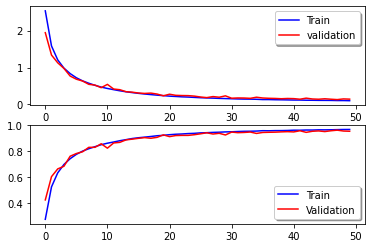

In [16]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(hist.history['loss'], color='b', label="Train")
ax[0].plot(hist.history['val_loss'], color='r', label="validation",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(hist.history['accuracy'], color='b', label="Train")
ax[1].plot(hist.history['val_accuracy'], color='r',label="Validation")
legend = ax[1].legend(loc='best', shadow=True)

In [17]:
# Obtain accuracy on test set
score = model.evaluate(x=x_test, 
                       y=y_test_OH,
                       verbose=0)
print('Test accuracy:', score[1])

Test accuracy: 0.9539655447006226
